# Advanced Deep Learning Models

**Ziel:** State-of-the-Art Modelle für Zeitreihenvorhersage

**Modelle:**
1. N-BEATS (Neural Basis Expansion Analysis)
2. N-HiTS (Hierarchical Interpolation for Time Series)
3. TFT (Temporal Fusion Transformer) - Optional

**Basierend auf:**
- Week09_Transformers+TFTs
- Week10_NBEATS+NHITS+xLSTMs

**Libraries:** Verwenden `darts` und `neuralforecast` für einfache Implementation

In [1]:
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

try:
    # Darts framework
    from darts import TimeSeries
    from darts.models import NBEATSModel, NHiTSModel, TFTModel
    from darts.dataprocessing.transformers import Scaler
    DARTS_AVAILABLE = True
    print("✅ Darts available")
except ImportError:
    print("⚠️ Darts not installed. Install with: pip install darts")
    DARTS_AVAILABLE = False

from evaluation.metrics import calculate_metrics, print_metrics, compare_models
from visualization.plots import plot_multiple_forecasts

plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

The StatsForecast module could not be imported. To enable support for the AutoARIMA, AutoETS and Croston models, please consider installing it.


✅ Darts available


## 1. Daten laden

In [2]:
DATA_TYPE = 'solar'
data_dir = Path('../data/processed')

train_df = pd.read_csv(data_dir / f'{DATA_TYPE}_train.csv', parse_dates=['timestamp'])
val_df = pd.read_csv(data_dir / f'{DATA_TYPE}_val.csv', parse_dates=['timestamp'])
test_df = pd.read_csv(data_dir / f'{DATA_TYPE}_test.csv', parse_dates=['timestamp'])

print(f"Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")

Train: 18262 | Val: 3913 | Test: 3914


## 2. Darts TimeSeries erstellen

In [3]:
if DARTS_AVAILABLE:
    # Convert to Darts TimeSeries
    train_series = TimeSeries.from_dataframe(
        train_df,
        time_col='timestamp',
        value_cols='value',
        freq='H'  # Hourly frequency
    )
    
    val_series = TimeSeries.from_dataframe(
        val_df,
        time_col='timestamp',
        value_cols='value',
        freq='H'
    )
    
    test_series = TimeSeries.from_dataframe(
        test_df,
        time_col='timestamp',
        value_cols='value',
        freq='H'
    )
    
    # Skalierung
    scaler = Scaler()
    train_scaled = scaler.fit_transform(train_series)
    val_scaled = scaler.transform(val_series)
    test_scaled = scaler.transform(test_series)
    
    print("✅ Darts TimeSeries created and scaled")
else:
    print("⚠️ Skipping Darts models - library not available")

✅ Darts TimeSeries created and scaled


## 3. N-BEATS Model

**N-BEATS** = Neural Basis Expansion Analysis for Interpretable Time Series

- Speziell für Zeitreihen entwickelt
- Interpretierbare Trend- und Saisonalitätskomponenten
- SOTA Performance ohne externe Features

In [4]:
if DARTS_AVAILABLE:
    print("Training N-BEATS...\n")
    print("⚠️ Dies kann mehrere Minuten dauern!\n")
    
    nbeats_model = NBEATSModel(
        input_chunk_length=24,  # Look back 24 hours
        output_chunk_length=24,  # Forecast 24 hours
        n_epochs=50,
        num_stacks=30,
        num_blocks=1,
        num_layers=4,
        layer_widths=256,
        batch_size=64,
        random_state=42,
        pl_trainer_kwargs={"accelerator": "auto"},
        force_reset=True
    )
    
    # Train
    nbeats_model.fit(
        train_scaled,
        val_series=val_scaled,
        verbose=True
    )
    
    # Predict
    nbeats_pred_scaled = nbeats_model.predict(n=len(test_series))
    nbeats_pred = scaler.inverse_transform(nbeats_pred_scaled)
    
    # Evaluation
    nbeats_metrics = calculate_metrics(
        test_series.values().flatten(),
        nbeats_pred.values().flatten(),
        prefix='test_'
    )
    print("\n")
    print_metrics(nbeats_metrics, "N-BEATS")
else:
    nbeats_metrics = None
    nbeats_pred = None

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.2 M  | train
-------------------------------------------------------------
6.2 M     Trainable params
1.4 K     Non-trainable params
6.2 M     Total params
24.796    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode


Training N-BEATS...

⚠️ Dies kann mehrere Minuten dauern!



Sanity Checking: |                                                                                        | 0/…

Training: |                                                                                               | 0/…

Validation: |                                                                                             | 0/…

Validation: |                                                                                             | 0/…

Validation: |                                                                                             | 0/…

Validation: |                                                                                             | 0/…

Validation: |                                                                                             | 0/…

Validation: |                                                                                             | 0/…

Validation: |                                                                                             | 0/…

Validation: |                                                                                             | 0/…

Validation: |                                                                                             | 0/…

Validation: |                                                                                             | 0/…

Validation: |                                                                                             | 0/…

Validation: |                                                                                             | 0/…

Validation: |                                                                                             | 0/…

Validation: |                                                                                             | 0/…

Validation: |                                                                                             | 0/…

Validation: |                                                                                             | 0/…

Validation: |                                                                                             | 0/…

Validation: |                                                                                             | 0/…

Validation: |                                                                                             | 0/…

Validation: |                                                                                             | 0/…

Validation: |                                                                                             | 0/…

Validation: |                                                                                             | 0/…

Validation: |                                                                                             | 0/…

Validation: |                                                                                             | 0/…

Validation: |                                                                                             | 0/…

Validation: |                                                                                             | 0/…

Validation: |                                                                                             | 0/…

Validation: |                                                                                             | 0/…

Validation: |                                                                                             | 0/…

Validation: |                                                                                             | 0/…

Validation: |                                                                                             | 0/…

Validation: |                                                                                             | 0/…

Validation: |                                                                                             | 0/…

Validation: |                                                                                             | 0/…

Validation: |                                                                                             | 0/…

Validation: |                                                                                             | 0/…

Validation: |                                                                                             | 0/…

Validation: |                                                                                             | 0/…

Validation: |                                                                                             | 0/…

Validation: |                                                                                             | 0/…

Validation: |                                                                                             | 0/…

Validation: |                                                                                             | 0/…

Validation: |                                                                                             | 0/…

Validation: |                                                                                             | 0/…

Validation: |                                                                                             | 0/…

Validation: |                                                                                             | 0/…

Validation: |                                                                                             | 0/…

Validation: |                                                                                             | 0/…

Validation: |                                                                                             | 0/…

Validation: |                                                                                             | 0/…

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                             | 0/…



                          N-BEATS                           
  test_mae       :    3382.69
  test_rmse      :    4263.60
  test_mape      :      59.55%
  test_smape     :      37.56%
  test_r2        :    -1.2853
  test_mase      :      11.59


## 4. N-HiTS Model

**N-HiTS** = Neural Hierarchical Interpolation for Time Series

- Verbesserung von N-BEATS
- Hierarchical multi-rate sampling
- Besonders gut für lange Horizonte

In [5]:
if DARTS_AVAILABLE:
    print("Training N-HiTS...\n")
    
    nhits_model = NHiTSModel(
        input_chunk_length=24,
        output_chunk_length=24,
        n_epochs=50,
        num_stacks=3,
        num_blocks=1,
        num_layers=2,
        layer_widths=512,
        batch_size=64,
        random_state=42,
        pl_trainer_kwargs={"accelerator": "auto"},
        force_reset=True
    )
    
    nhits_model.fit(
        train_scaled,
        val_series=val_scaled,
        verbose=True
    )
    
    nhits_pred_scaled = nhits_model.predict(n=len(test_series))
    nhits_pred = scaler.inverse_transform(nhits_pred_scaled)
    
    nhits_metrics = calculate_metrics(
        test_series.values().flatten(),
        nhits_pred.values().flatten(),
        prefix='test_'
    )
    print("\n")
    print_metrics(nhits_metrics, "N-HiTS")
else:
    nhits_metrics = None
    nhits_pred = None

Training N-HiTS...



GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 841 K  | train
-------------------------------------------------------------
829 K     Trainable params
12.3 K    Non-trainable params
841 K     Total params
3.367     Total estimated model params size (MB)
42        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                        | 0/…

Training: |                                                                                               | 0/…

Validation: |                                                                                             | 0/…

Validation: |                                                                                             | 0/…

Validation: |                                                                                             | 0/…

Validation: |                                                                                             | 0/…

Validation: |                                                                                             | 0/…

Validation: |                                                                                             | 0/…

Validation: |                                                                                             | 0/…

Validation: |                                                                                             | 0/…

Validation: |                                                                                             | 0/…

Validation: |                                                                                             | 0/…

Validation: |                                                                                             | 0/…

Validation: |                                                                                             | 0/…

Validation: |                                                                                             | 0/…

Validation: |                                                                                             | 0/…

Validation: |                                                                                             | 0/…

Validation: |                                                                                             | 0/…

Validation: |                                                                                             | 0/…

Validation: |                                                                                             | 0/…

Validation: |                                                                                             | 0/…

Validation: |                                                                                             | 0/…

Validation: |                                                                                             | 0/…

Validation: |                                                                                             | 0/…

Validation: |                                                                                             | 0/…

Validation: |                                                                                             | 0/…

Validation: |                                                                                             | 0/…

Validation: |                                                                                             | 0/…

Validation: |                                                                                             | 0/…

Validation: |                                                                                             | 0/…

Validation: |                                                                                             | 0/…

Validation: |                                                                                             | 0/…

Validation: |                                                                                             | 0/…

Validation: |                                                                                             | 0/…

Validation: |                                                                                             | 0/…

Validation: |                                                                                             | 0/…

Validation: |                                                                                             | 0/…

Validation: |                                                                                             | 0/…

Validation: |                                                                                             | 0/…

Validation: |                                                                                             | 0/…

Validation: |                                                                                             | 0/…

Validation: |                                                                                             | 0/…

Validation: |                                                                                             | 0/…

Validation: |                                                                                             | 0/…

Validation: |                                                                                             | 0/…

Validation: |                                                                                             | 0/…

Validation: |                                                                                             | 0/…

Validation: |                                                                                             | 0/…

Validation: |                                                                                             | 0/…

Validation: |                                                                                             | 0/…

Validation: |                                                                                             | 0/…

Validation: |                                                                                             | 0/…

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                             | 0/…



                           N-HiTS                           
  test_mae       :    4628.96
  test_rmse      :    5363.60
  test_mape      :      49.31%
  test_smape     :      66.81%
  test_r2        :    -2.6166
  test_mase      :      15.86


## 5. Temporal Fusion Transformer (TFT) - Optional

**TFT** kombiniert:
- Attention mechanisms
- Variable selection networks
- Interpretierbare outputs
- Kann exogene Variablen nutzen

**Achtung:** Sehr rechenintensiv!

In [6]:
TRAIN_TFT = False  # Setze auf True wenn gewünscht (kann sehr lange dauern!)

if DARTS_AVAILABLE and TRAIN_TFT:
    print("Training TFT...\n")
    print("⚠️ Dies kann sehr lange dauern (10-30+ Minuten)!\n")
    
    tft_model = TFTModel(
        input_chunk_length=24,
        output_chunk_length=24,
        hidden_size=64,
        lstm_layers=1,
        num_attention_heads=4,
        dropout=0.1,
        n_epochs=30,
        batch_size=64,
        random_state=42,
        pl_trainer_kwargs={"accelerator": "auto"},
        force_reset=True
    )
    
    tft_model.fit(
        train_scaled,
        val_series=val_scaled,
        verbose=True
    )
    
    tft_pred_scaled = tft_model.predict(n=len(test_series))
    tft_pred = scaler.inverse_transform(tft_pred_scaled)
    
    tft_metrics = calculate_metrics(
        test_series.values().flatten(),
        tft_pred.values().flatten(),
        prefix='test_'
    )
    print("\n")
    print_metrics(tft_metrics, "TFT")
else:
    print("ℹ️ TFT übersprungen (TRAIN_TFT=False oder Darts nicht verfügbar)")
    tft_metrics = None
    tft_pred = None

ℹ️ TFT übersprungen (TRAIN_TFT=False oder Darts nicht verfügbar)


## 6. Model Comparison

In [7]:
if DARTS_AVAILABLE:
    all_results = {}
    
    if nbeats_metrics:
        all_results['N-BEATS'] = nbeats_metrics
    if nhits_metrics:
        all_results['N-HiTS'] = nhits_metrics
    if tft_metrics:
        all_results['TFT'] = tft_metrics
    
    if all_results:
        comparison_df = compare_models(all_results, sort_by='test_rmse')
        
        print("\n" + "=" * 80)
        print("ADVANCED MODELS - COMPARISON")
        print("=" * 80)
        display(comparison_df.round(2))
        
        best_model = comparison_df['test_rmse'].idxmin()
        print(f"\n🏆 Best Model: {best_model}")
    else:
        print("⚠️ Keine Modelle erfolgreich trainiert")
else:
    print("⚠️ Vergleich nicht möglich - Darts nicht verfügbar")


ADVANCED MODELS - COMPARISON


,test_mae,test_rmse,test_mape,test_smape,test_r2,test_mase
N-BEATS,3382.69,4263.6,59.55,37.56,-1.29,11.59
N-HiTS,4628.96,5363.6,49.31,66.81,-2.62,15.86



🏆 Best Model: N-BEATS


## 7. Visualisierung

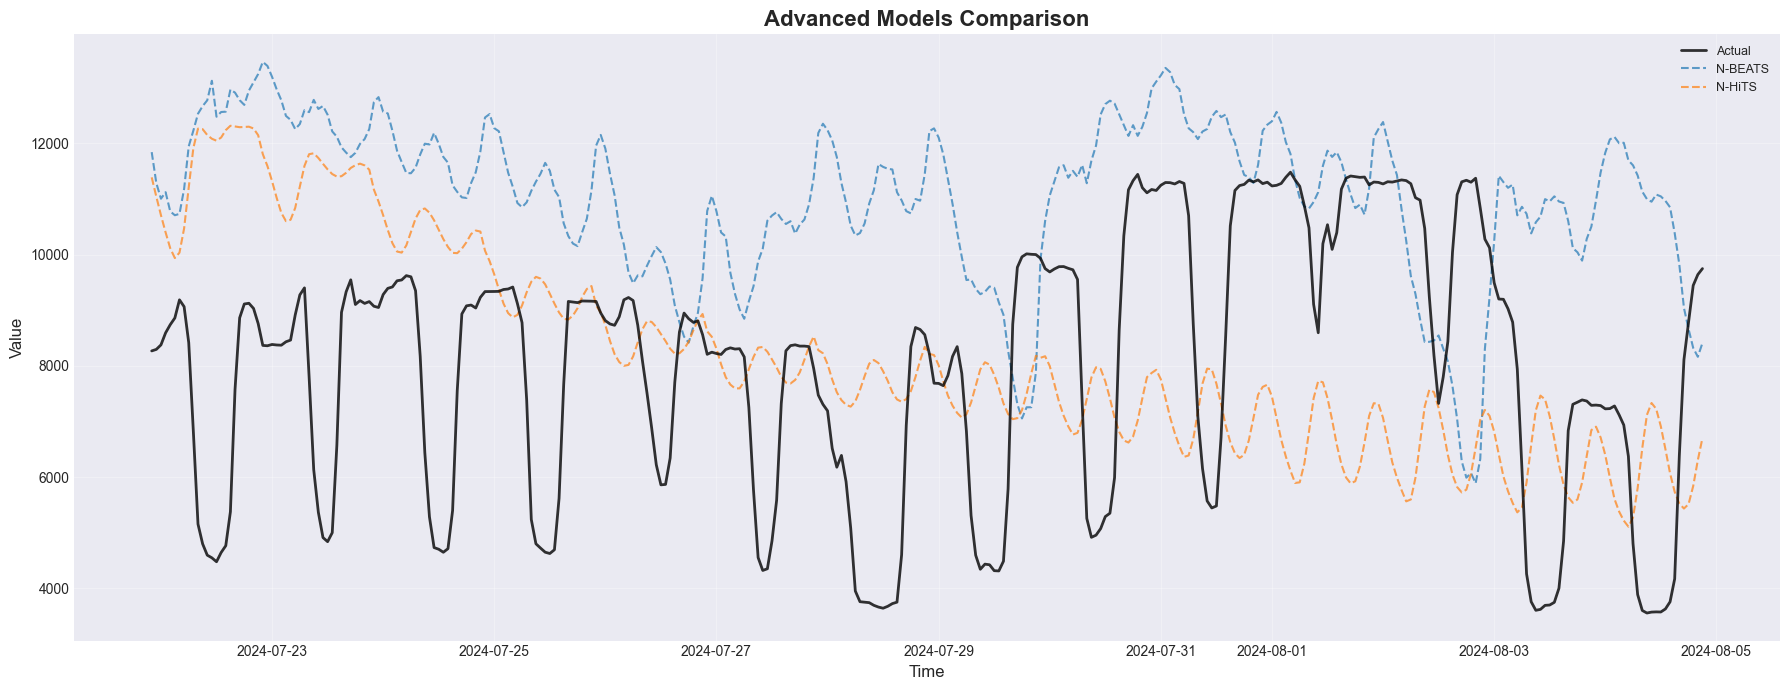

In [8]:
if DARTS_AVAILABLE and nbeats_pred is not None:
    plot_window = 168 * 2  # 2 Wochen
    
    forecasts = {}
    
    if nbeats_pred:
        forecasts['N-BEATS'] = nbeats_pred.values().flatten()[:plot_window]
    if nhits_pred:
        forecasts['N-HiTS'] = nhits_pred.values().flatten()[:plot_window]
    if tft_pred:
        forecasts['TFT'] = tft_pred.values().flatten()[:plot_window]
    
    plot_multiple_forecasts(
        test_df['timestamp'].iloc[:plot_window],
        test_df['value'].values[:plot_window],
        forecasts,
        title="Advanced Models Comparison",
        figsize=(18, 7)
    )
else:
    print("⚠️ Visualisierung nicht möglich")

## 8. Ergebnisse speichern

In [9]:
if DARTS_AVAILABLE and 'comparison_df' in locals():
    results_dir = Path('../results/metrics')
    results_dir.mkdir(parents=True, exist_ok=True)
    
    comparison_df.to_csv(results_dir / f'{DATA_TYPE}_advanced_results.csv')
    print("✅ Ergebnisse gespeichert")
else:
    print("ℹ️ Keine Ergebnisse zu speichern")

✅ Ergebnisse gespeichert


## 9. Zusammenfassung

### Erkenntnisse:

1. **N-BEATS**:
   - Speziell für Zeitreihen entwickelt
   - Interpretierbare Komponenten (Trend, Saisonalität)
   - Keine Features nötig
   - SOTA Performance

2. **N-HiTS**:
   - Verbesserte Version von N-BEATS
   - Besonders gut für lange Horizonte
   - Hierarchical sampling

3. **TFT**:
   - Transformer-basiert
   - Attention mechanisms
   - Kann exogene Variablen nutzen
   - Sehr rechenintensiv

### Vorteile dieser Modelle:

- ✅ State-of-the-Art Performance
- ✅ Automatisches Feature Learning
- ✅ Interpretierbarkeit (N-BEATS, TFT)
- ✅ Probabilities und Quantile möglich

### Nachteile:

- ⚠️ Lange Trainingszeit
- ⚠️ Viele Hyperparameter
- ⚠️ Benötigen viele Daten
- ⚠️ GPU empfohlen

### Nächste Schritte:

**Final Comparison** → `08_model_comparison.ipynb`
- Alle Modelle vergleichen
- Ensemble-Methoden
- Finale Evaluation

## Installation Notes

Falls `darts` nicht installiert ist:

```bash
pip install darts
pip install pytorch-lightning
```

Für neuralforecast:

```bash
pip install neuralforecast
```